In [5]:
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import sympy as sm
import func
import time
%reload_ext line_profiler

In [34]:
def utility(c,theta):
    ''' Utility function for consumption including the limit case for rho->1 '''
    '''not actually used because direct calculation is faster'''
    if c<0:
        raise error
    if rho !=1 :
        return (c**(1-theta)-1)/(1-theta)
    else:
        return np.log(c)

def total_utility(c, beta, theta):
    '''
    Sums utility for c for multiple years
    c is an array 
    '''
    t_u = np.sum([beta**i*(ct**(1-theta)-1)/(1-theta) for ct in c]) 
    return t_u

def prod(k,l,alpha,b):
    return b*k**alpha*l**(1-alpha)

In [36]:
def tot_ut_sk(sk,t, k0, l, b, beta, alpha, theta, delta, quick=True):
    '''
    Returns utitlity for  given period 
    depending on initial amount of kapital, k0,
    and a fixed savingsrate, sk, for all periods 
    '''
    k_short = np.empty(t)
    c_short = np.empty(t)
    y_short = np.empty(t)
    k_short[0] = k0
    for i in range(t):
        y_short[i] = prod(k_short[i],l[i],alpha,b)
        c_short[i]=(1-sk)*y_short[i]
        if i+1<t:
            k_short[i+1]=sk*y_short[i]+(1-delta)*k_short[i] 
    if quick:
        return total_utility(c_short,beta,theta)
    else:
        return k_short,c_short,y_short

def opt_sk(t, b, beta, delta, alpha, theta, k0,l):
    '''Finds optimal fixed savings rate, sk, 
    for maximal total utility '''
    obj = lambda sk: -tot_ut_sk(sk,t,k0, l, b, beta, alpha, theta, delta)
    res = optimize.minimize_scalar(obj, alpha, method='bounded',bounds=[0,1])
    return res.x

# Fast opsparingsrate

analytisk

In [83]:
sm.init_printing(use_unicode=True)

In [89]:
#valgmuligheder:
# andelen af mulig arbejdstid som bruges på forskning:
sr = sm.symbols('s_Rt')
# I starten antages kapitalopspsparingsraten at være konstant
sk = sm.symbols('s_Kt')
# Ud fra de valg nogle udfald
# Først defineres variable
l = sm.symbols('L_{t}')
ly = sm.symbols('L_{Yt}')
la = sm.symbols('L_{At}')
alpha = sm.symbols('alpha')
k =sm.symbols('K_{t}')
k1 = sm.symbols('K_{t+1}')
y = sm.symbols('Y_{t}')
c = sm.symbols('C')
ct = sm.symbols('C_{t}')
a = sm.symbols('A_{t}')
a1 = sm.symbols('A_{t+1}')
r = sm.symbols('r')

#Greek:
rho = sm.symbols('rho')
beta = sm.symbols('beta')
alpha = sm.symbols('alpha')
phi = sm.symbols('phi')
delta = sm.symbols('delta')
theta = sm.symbols('theta')

t = sm.symbols('t')
ts = sm.symbols('T')
# Functions:
uc = sm.Function('u')(ct) 
u = sm.Function('U')(c)

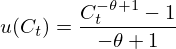

In [87]:
sm.Eq(uc,(ct**(1-theta)-1)/(1-theta))

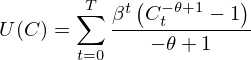

In [91]:
sm.Eq(u,sm.Sum(beta**t*(ct**(1-theta)-1)/(1-theta),(t,0,ts)))

In [106]:
sm.init_printing(use_unicode=False)

Nummerisk

In [59]:
theta = 0.5
alpha = 1/3
delta = 0.05
rho = 0.5
n=0.008

In [61]:
t = 1000
b = 10
k0 = 10
l = [(1+n)**i for i in range(t)]
beta = 0.9

In [63]:
n = 100
ks = np.linspace(0.1,200,n)
sks = np.zeros(n)
for i,k in enumerate(ks):
    sks[i] = opt_sk(t, b, beta,delta,alpha,theta,k,l)

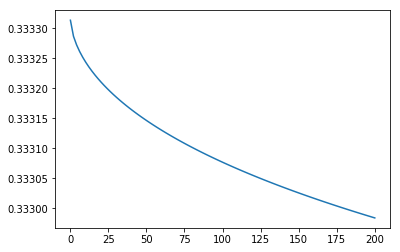

In [64]:
func.plot(ks,sks)

# Need speed?

In [81]:
def opt_sk1(t, b, beta, delta, alpha, theta, k0, l):
    '''Finds optimal fixed savings rate, sk, 
    for maximal total utility '''
    obj = lambda sk: -tot_ut_sk(sk,t,k0, l, b, beta, alpha, theta, delta)
    res = optimize.minimize_scalar(obj, alpha, method='bounded',bounds=[0,1])
    return res.x

In [69]:
def tot_ut_sk2(sk,t, k0, l, b, beta, alpha, theta, delta):
    '''
    Returns utitlity for  given period 
    depending on initial amount of kapital, k0,
    and a fixed savingsrate, sk, for all periods 
    '''
    k_short = np.empty(t)
    k_short[0] = k0
    
    for i in range(1,t):
        k_short[i]=sk*prod(k_short[i-1],l[i-1],alpha,b)+(1-delta)*k_short[i-1] 
    
    return total_utility((1-sk)*prod(k_short[i-1],l[i-1],alpha,b),beta,theta)
    

In [91]:
def opt_sk2(t, b, beta, delta, alpha, theta, k0, l):
    '''Finds optimal fixed savings rate, sk, 
    for maximal total utility '''
    obj = lambda sk: -tot_ut_sk2(sk,t,k0,l, b, beta, alpha, theta, delta)
    res = optimize.minimize_scalar(obj, alpha, method='bounded',bounds=[0,1])
    return res.x

In [83]:
def loop1(n):
    for i in range(n):
        opt_sk1(t, b, beta, delta, alpha, theta, k0,l)

In [92]:
def loop2(n):
    for i in range(n):
        opt_sk2(t, b, beta, delta, alpha, theta, k0,l)

In [87]:
n = 100

In [89]:
%lprun -f opt_sk1 -f loop1 loop1(n)

Timer unit: 1e-06 s

Total time: 5.31795 s
File: <ipython-input-81-dc2ccc10dfc5>
Function: opt_sk1 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def opt_sk1(t, b, beta, delta, alpha, theta, k0, l):
     2                                               '''Finds optimal fixed savings rate, sk, 
     3                                               for maximal total utility '''
     4       100        130.0      1.3      0.0      obj = lambda sk: -tot_ut_sk(sk,t,k0, l, b, beta, alpha, theta, delta)
     5       100    5317173.0  53171.7    100.0      res = optimize.minimize_scalar(obj, alpha, method='bounded',bounds=[0,1])
     6       100        646.0      6.5      0.0      return res.x

Total time: 5.31889 s
File: <ipython-input-83-186312989a80>
Function: loop1 at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def loop1(n):
     2       101 

In [93]:
%lprun -f opt_sk2 -f loop2 loop2(n)

TypeError: 'numpy.float64' object is not iterable

# Varierende opsparingsrate

In [173]:
def tot_ut_multiple_sks(sks, k0, l, b, beta, theta, alpha, delta, vector=False):
    '''
    Finds total utitilty for a set of years with a savingsrate for each year
    '''
    t = len(sks)
    k_short = np.empty(t)
    k_short[0] = k0
    
    for i in range(1,t):    
        k_short[i]=sks[i-1]*prod(k_short[i-1],l,alpha,b)+(1-delta)*k_short[i-1]
    y_short = [prod(k,l,alpha,b) for k in k_short]
    if vector==False:
        return total_utility(y_short*(1-sks), beta, theta)
    elif vector==True:
        return total_utility(y_short*(1-sks), beta, theta), y_short, y_short*(1-sks), k_short

In [170]:
theta = 0.9
alpha = 1/3
delta = 0.05
beta = 1
b = 10
k0 = 1
l = 10

In [174]:
t = 50
obj = lambda sks: -tot_ut_multiple_sks(sks, k0, l, b, beta, theta, alpha, delta)
sks0 = np.full(t,0.3)
sks0[-1] = 0
bounds = np.full((t,2),[0,1])


res = optimize.minimize(obj, sks0, method='SLSQP', bounds=bounds)

print(f'Optimal sk')
np.set_printoptions(precision=4,suppress=True)
print(res.x)
print('Total utility:')
print(f'{-res.fun:.4f}')

Optimal sk
[0.615  0.6442 0.6287 0.6045 0.5803 0.5577 0.537  0.5179 0.5003 0.484
 0.4686 0.4541 0.4404 0.4272 0.4145 0.4022 0.3903 0.3785 0.3669 0.3552
 0.3435 0.3317 0.3197 0.3073 0.2944 0.281  0.2668 0.2517 0.2356 0.2184
 0.1996 0.1789 0.1559 0.1301 0.1011 0.0679 0.029  0.     0.     0.
 0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
Total utility:
406.0197


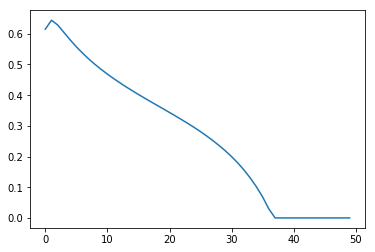

In [175]:
func.plot(range(t),res.x)

In [176]:
def optimal_sks(t, b, l, beta, delta, alpha, theta, k0, first=True):
    obj = lambda sks: -tot_ut_multiple_sks(sks, k0, l, b, beta, theta, alpha, delta)
    sks0 = np.full(t,alpha)
    sks0[-1] = 0
    bounds = np.full((t,2),[0,1])
    res = optimize.minimize(obj, sks0, method='SLSQP', bounds=bounds)
    if res.success == False:
        print('Optimization was sadly not succesfull')
    elif first:
        return res.x[0]
    else:
        return res.x

In [165]:
theta = 0.9
alpha = 1/3
delta = 0.05
beta = 1
b = 2
beta = 0.99
k0 = 40
l = 1
t = 100

In [166]:
sks = optimal_sks(t, b, l, beta, delta, alpha, theta, k0, first=False)
total, y, c, k = tot_ut_multiple_sks(sks, k0, l, b, beta, theta, alpha, delta, vector=True)

NameError: name 'tot_ut_multiple_sks' is not defined

In [ ]:
sks_alt = np.array([alpha for i in list(range(t))])
total_alt, y_alt, c_alt, k_alt = tot_ut_multiple_sks(sks_alt, k0, l, b, beta, theta, alpha, delta, vector=True)

In [ ]:
func.plot2(range(t),sks,sks_alt)
func.plot2(range(t),k,k_alt)
func.plot2(range(t),c,c_alt)

In [ ]:
ks = np.linspace(0.1,100,100)
sks1 = np.empty(100)

for i, k in enumerate(ks):
    sks1[i] = optimal_sks(t, b, l, beta, delta, alpha, theta, k)

In [ ]:
func.plot(ks,sks1)

In [ ]:
ks = np.linspace(1,600,50)
sks1 = np.empty(50)

for i, k in enumerate(ks):
    sks1[i] = optimal_sks(t, b, beta, delta, alpha, theta, k)

In [ ]:
func.plot(ks,sks1)

# Need for speed

In [ ]:
%time sk = optimal_sks(t, b, l, beta, delta, alpha, theta, k0)

In [ ]:
%lprun -f tot_ut_multiple_sks -f optimal_sks optimal_sks(t, b, l, beta, delta, alpha, theta, k0)